In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# !cp -avr /content/drive/'My Drive'/DetectingSarcasm .

In [0]:
# %cd DetectingSarcasm/Notebooks

In [0]:
# !ls

In [0]:
import sys
sys.path.append('../Models')
sys.path.append('../')

In [0]:
import torch
from torchtext import data

import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

import spacy

import time
import copy
from torch.optim import lr_scheduler

from torchtext.vocab import Vectors, GloVe
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from utils import *

Let's look at our dataset:

In [7]:
df = pd.read_json("../Data/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


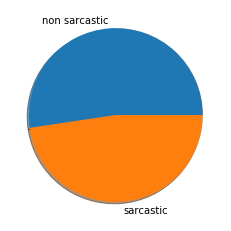

In [8]:
x = df['is_sarcastic'].value_counts()
plt.pie(x, labels = ['non sarcastic', 'sarcastic'], shadow=True)
plt.show()

Counting number of headlines with appropriate number of words:

In [9]:
count = df['headline'].str.split().apply(len).value_counts()
count

10     3638
9      3425
11     3396
8      2935
12     2841
7      2404
13     2083
6      1762
14     1492
5      1164
15      969
4       591
16      578
17      383
3       306
18      228
19      143
2       118
20       63
21       45
22       23
23       12
24        5
27        3
25        2
28        2
29        2
31        1
38        1
39        1
26        1
30        1
151       1
Name: headline, dtype: int64

We can see, that most part of headlines has less then 24 words. We will use 
this fact for choosing length of sequence.

Dropping unusefull column:

In [10]:
df = df.drop(['article_link'], axis=1)
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [0]:
text = df['headline']
target = df['is_sarcastic']

In [0]:
!mkdir torchtext_data

Loading test and train sets to csv:

We will use 20% of dataset as test set.

In [0]:
split_and_save(text, target, test_size=0.2)

Preparing the data:

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
fix_length = 24
TEXT = data.Field(sequential=True, tokenize="spacy", fix_length=fix_length)
LABEL = data.LabelField(dtype=torch.long, sequential=False)

In [0]:
train_data, test_data = data.TabularDataset.splits(
    path="torchtext_data/", train="train.csv", 
    test="test.csv",format="csv", skip_header=True, 
    fields=[('Text', TEXT), ('Label', LABEL)]
)

In [0]:
batch_size = 16

train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data), sort_key=lambda x: len(x.Text),
    batch_size=batch_size,
    device=device)

In [18]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 22895
Number of testing examples: 5724


Making vocabluary with GloVe with dimantion of 300:

In [0]:
TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300))
LABEL.build_vocab(train_data)

In [0]:
word_embeddings = TEXT.vocab.vectors
output_size = 2 #two classes
num_layers = 1
hidden_size = 128 #num of units in our NN
embedding_length = 300 #dim of GloVe vector
vocab_size = len(TEXT.vocab)

Defining the model:


*   Simple LSTM - LSTMClassifier class 
*   LSTM with Attanrion - AttantionLSTMClassifier class 
*   Bidirectional LSTM - BidirectionalLSTMClassifier class
*   Bidirectional LSTM with 2D MaxPool layer - LSTM2DMaxPoolClassifier class





In [0]:
from LSTM2DMaxPool import *

In [0]:
model = LSTM2DMaxPoolClassifier(batch_size, output_size, hidden_size, vocab_size, embedding_length, num_layers, word_embeddings)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.000174282, weight_decay=4.62355e-05)
criterion = nn.CrossEntropyLoss()

In [0]:
model = model.to(device)
criterion = criterion.to(device)

In [0]:
dataiter_dict = {'train': train_iterator, 'val': test_iterator}
dataset_sizes = {'train':len(train_data), 'val':len(test_data)}

Train model:

In [26]:
model_fit, res = train_model(model,
                             criterion,
                             optimizer,
                             scheduler = None,
                             dataiter_dict = dataiter_dict,
                             dataset_sizes = dataset_sizes,
                             batch_size = batch_size,
                             num_epochs=20)

starting
Epoch 1/20
----------
train total loss: 0.8824 
train sentiment_acc: 0.6914
val total loss: 0.7712 
val sentiment_acc: 0.7872
saving with loss of 0.7711790041603632 improved over previous 200

Epoch 2/20
----------
train total loss: 0.7408 
train sentiment_acc: 0.8103
val total loss: 0.7277 
val sentiment_acc: 0.8208
saving with loss of 0.7276738865820367 improved over previous 0.7711790041603632

Epoch 3/20
----------
train total loss: 0.7052 
train sentiment_acc: 0.8355
val total loss: 0.7082 
val sentiment_acc: 0.8286
saving with loss of 0.7082381089778317 improved over previous 0.7276738865820367

Epoch 4/20
----------
train total loss: 0.6775 
train sentiment_acc: 0.8545
val total loss: 0.7168 
val sentiment_acc: 0.8220

Epoch 5/20
----------
train total loss: 0.6574 
train sentiment_acc: 0.8692
val total loss: 0.6954 
val sentiment_acc: 0.8414
saving with loss of 0.6953721928646479 improved over previous 0.7082381089778317

Epoch 6/20
----------
train total loss: 0.6418 

Lets see at test and train accuracy plots:

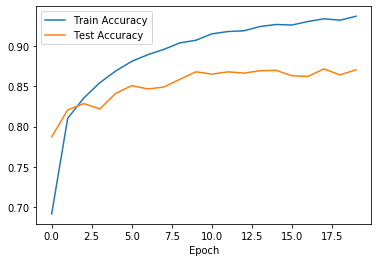

In [27]:
plt.plot(res['train_acc'], label = 'Train Accuracy')
plt.plot(res['val_acc'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

And confusion matrix:

In [28]:
pd.DataFrame(res['conf_matr'], index=['pred pos', 'pred neg'], columns=['actual pos', 'actual neg'])

,actual pos,actual neg
pred pos,2443,452
pred neg,276,2541


In [29]:
pd.DataFrame([float(res['f1']),
              float(res['precision']), 
              float(res['recall'])], 
              index = ['f1 score', 'precision', 'recall'],
              columns=[''])

,
f1 score,0.870324
precision,0.843869
recall,0.898492
